In [58]:
from shapely.geometry import box, Point, LineString
import pyrosm
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from scipy import stats
import geopandas
import pandas as pd
import numpy as np
import random
import networkx as nx
import math
from rasterio.crs import CRS
from sys import getsizeof

In [59]:
pd.options.display.max_columns = 50
OUT_CRS = CRS.from_epsg(27700)  # https://epsg.io/27700

In [60]:
# convenience function for printing
def print_size(obj, suffix='B'):
    num = getsizeof(obj)
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    print("%.1f%s%s" % (num, 'Yi', suffix))

In [61]:
%%time
import pickle
from pathlib import Path

class Person():
    def __init__(self, uid, household_uid, age, pos):
        self.uid = uid
        self.household_uid = household_uid
        self.age = age
        self.pos = pos
    
# households_gdf = pickle.loads(Path('pickles/london/households_gdf').read_bytes())
people = pickle.loads(Path('../pickles/london/people_list').read_bytes())
trimmed_work = pickle.loads(Path('../pickles/london/workplaces_gdf').read_bytes())
boundary = pickle.loads(Path('../pickles/london/boundary').read_bytes())

CPU times: user 25.2 s, sys: 4.75 s, total: 29.9 s
Wall time: 30.2 s


<AxesSubplot:>

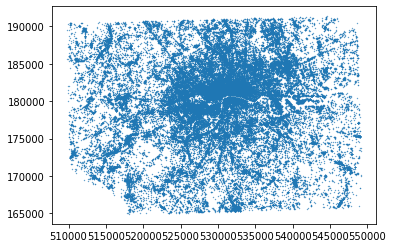

In [62]:
trimmed_work = trimmed_work.to_crs(OUT_CRS)
trimmed_work.plot(markersize=0.1)

In [63]:
%%time
# get all public transport
full_edges = pd.read_csv('../../data/uk_aggregate/Data_Release_v1.11/edges.csv')
full_nodes = pd.read_csv('../../data/uk_aggregate/Data_Release_v1.11/nodes.csv')
full_nodes = geopandas.GeoDataFrame(full_nodes, geometry=geopandas.points_from_xy(full_nodes.lon, full_nodes.lat), crs="EPSG:4326")
layers = pd.read_csv('../../data/uk_aggregate/Data_Release_v1.11/layers.csv')

# Clip the nodes to the boundary
nodes = geopandas.clip(full_nodes, boundary)
# Only select edges that start or end at the clipped nodes
des_edges = full_edges[full_edges.rename(columns={'des_node': 'node', 'des_layer': 'layer'}).set_index(['node', 'layer']).index.isin(nodes.set_index(['node', 'layer']).index)]
ori_edges = full_edges[full_edges.rename(columns={'ori_node': 'node', 'ori_layer': 'layer'}).set_index(['node', 'layer']).index.isin(nodes.set_index(['node', 'layer']).index)]
unclipped_edges = des_edges.merge(ori_edges) # inner merge to get edges that start and end in the boundary

CPU times: user 3.45 s, sys: 93.8 ms, total: 3.55 s
Wall time: 3.59 s


In [64]:
%%time
# Draw lines for the edges
old_index = full_nodes.index
full_nodes = full_nodes.set_index(['node', 'layer'])
unclipped_edges = geopandas.GeoDataFrame(unclipped_edges, geometry=unclipped_edges.apply(lambda x: LineString([
    full_nodes.loc[(x.ori_node, x.ori_layer)].geometry, 
    full_nodes.loc[(x.des_node, x.des_layer)].geometry
]), axis=1))
full_nodes = full_nodes.reset_index()
full_nodes.index = old_index

# commented for now as we require des AND ori nodes to be within the boundary instead of OR
# Clip those edges to the boundary too
# edges = geopandas.clip(unclipped_edges.reset_index(), boundary)  
# Get rid of empty geometries
#edges = edges[~edges.is_empty]
edges = unclipped_edges

CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 10.1 s


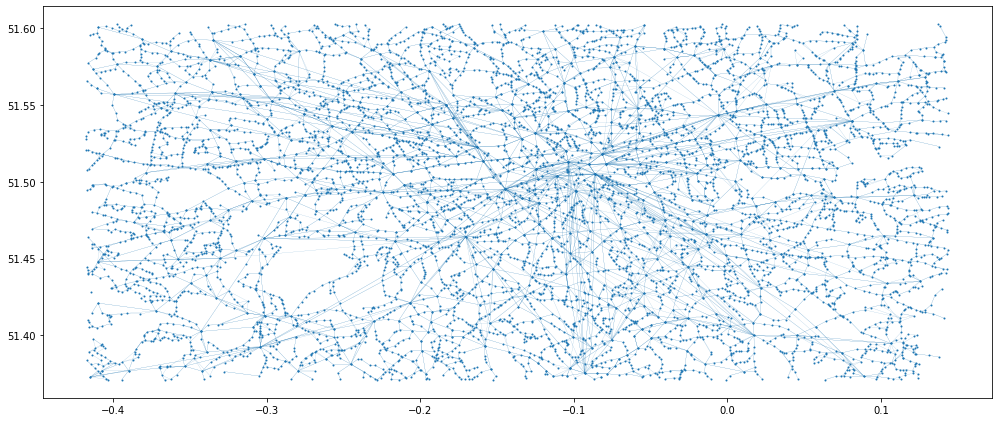

In [65]:
fig, ax = plt.subplots(figsize=(17, 17))
nodes.plot(ax=ax, markersize=1)
edges.plot(ax=ax, linewidth=0.1)
del fig, ax

In [66]:
nodes['osmid'] = nodes['node'].astype(str) + '_' + nodes['layer'].astype(str)
nodes['x'] = nodes.geometry.x
nodes['y'] = nodes.geometry.y
nodes.set_index('osmid', verify_integrity=True, inplace=True, drop=False) # keep the column as osmnx needs it (as well as it being the index of the DF)
nodes

,node,layer,lat,lon,zone,atcocode,geometry,osmid,x,y
osmid,,,,,,,,,,
20_5,20,5,51.45774,-0.12900,490,490G00009460,POINT (-0.12900 51.45774),20_5,-0.12900,51.45774
38_5,38,5,51.54389,-0.37527,490,490G00006638,POINT (-0.37527 51.54389),38_5,-0.37527,51.54389
63_5,63,5,51.47080,-0.27344,490,490G00005409,POINT (-0.27344 51.47080),63_5,-0.27344,51.47080
154_5,154,5,51.48817,-0.13813,490,490G00011004,POINT (-0.13813 51.48817),154_5,-0.13813,51.48817
172_5,172,5,51.47339,0.09551,490,490G00013375,POINT (0.09551 51.47339),172_5,0.09551,51.47339
...,...,...,...,...,...,...,...,...,...,...
262309_5,262309,5,51.47950,-0.33518,490,490010132N2,POINT (-0.33518 51.47950),262309_5,-0.33518,51.47950
262313_5,262313,5,51.49935,-0.38216,490,490003966D,POINT (-0.38216 51.49935),262313_5,-0.38216,51.49935
262325_5,262325,5,51.52295,-0.13289,490,490013720S,POINT (-0.13289 51.52295),262325_5,-0.13289,51.52295


In [67]:
edges['u'] = edges['ori_node'].astype(str) + '_' + edges['ori_layer'].astype(str)
edges['v'] = edges['des_node'].astype(str) + '_' + edges['des_layer'].astype(str)
edges['key'] = edges.reset_index()['index']
edges['osmid'] = edges['u'].astype(str) + '_' + edges['v'].astype(str)
edges.set_index(['u', 'v', 'key'], inplace=True)
edges = edges.set_crs("EPSG:4326")
edges

ori_node  des_node  ori_layer  des_layer  minutes  \
u        v        key                                                        
2097_1   43789_1  0          2097     43789          1          1        5   
         46521_1  1          2097     46521          1          1       60   
2676_1   14575_1  2          2676     14575          1          1        5   
7351_1   25717_1  3          7351     25717          1          1       14   
8515_1   12836_1  4          8515     12836          1          1        5   
...                           ...       ...        ...        ...      ...   
94175_5  94175_4  16237     94175     94175          5          4        1   
228492_5 228492_3 16238    228492    228492          5          3        1   
228492_3 228492_5 16239    228492    228492          3          5        1   
231447_4 231447_5 16240    231447    231447          4          5        1   
231447_5 231447_4 16241    231447    231447          5          4        1   

                            km  \
u        v        key            
2097_1   43789_1  0      0.960   
         46521_1  1      4.855   
2676_1   14575_1  2      1.483   
7351_1   25717_1  3      2.710   
8515_1   12836_1  4      0.302   
...                        ...   
94175_5  94175_4  16237  0.000   
228492_5 228492_3 16238  0.000   
228492_3 228492_5 16239  0.000   
231447_4 231447_5 16240  0.000   
231447_5 231447_4 16241  0.000   

                                                                  geometry  \
u        v        key                                                        
2097_1   43789_1  0      LINESTRING (-0.30117 51.41275, -0.30856 51.40543)   
         46521_1  1      LINESTRING (-0.30117 51.41275, -0.30504 51.45642)   
2676_1   14575_1  2      LINESTRING (-0.18282 51.47495, -0.16575 51.48305)   
7351_1   25717_1  3      LINESTRING (-0.12523 51.49212, -0.09635 51.50863)   
8515_1   12836_1  4        LINESTRING (0.06079 51.49777, 0.06209 51.49517)   
...                                                                    ...   
94175_5  94175_4  16237  LINESTRING (-0.07712 51.48971, -0.07712 51.48971)   
228492_5 228492_3 16238  LINESTRING (-0.06047 51.39961, -0.06047 51.39961)   
228492_3 228492_5 16239  LINESTRING (-0.06047 51.39961, -0.06047 51.39961)   
231447_4 231447_5 16240  LINESTRING (-0.19968 51.49324, -0.19968 51.49324)   
231447_5 231447_4 16241  LINESTRING (-0.19968 51.49324, -0.19968 51.49324)   

                                     osmid  
u        v        key                       
2097_1   43789_1  0         2097_1_43789_1  
         46521_1  1         2097_1_46521_1  
2676_1   14575_1  2         2676_1_14575_1  
7351_1   25717_1  3         7351_1_25717_1  
8515_1   12836_1  4         8515_1_12836_1  
...                                    ...  
94175_5  94175_4  16237    94175_5_94175_4  
228492_5 228492_3 16238  228492_5_228492_3  
228492_3 228492_5 16239  228492_3_228492_5  
231447_4 231447_5 16240  231447_4_231447_5  
231447_5 231447_4 16241  231447_5_231447_4  

[16242 rows x 8 columns]

In [68]:
import osmnx
graph = osmnx.utils_graph.graph_from_gdfs(nodes, edges, None)

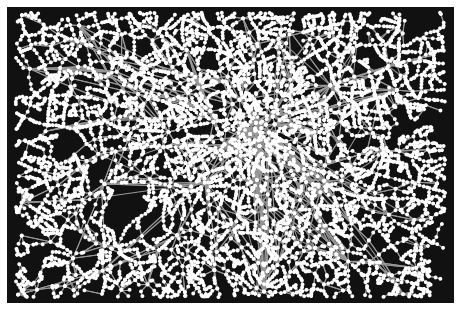

In [69]:
fig, ax = osmnx.plot_graph(graph)

In [70]:
osmnx.utils_graph.graph_to_gdfs(graph, nodes=False)

ori_node  des_node  ori_layer  des_layer  minutes  \
u       v       key                                                        
2097_1  43789_1 0          2097     43789          1          1        5   
        46521_1 1          2097     46521          1          1       60   
        2097_2  14869      2097      2097          1          2        6   
        2097_5  14871      2097      2097          1          5        7   
43789_1 2097_1  39        43789      2097          1          1        5   
...                         ...       ...        ...        ...      ...   
11530_4 11530_5 15146     11530     11530          4          5        1   
30499_1 30499_5 15669     30499     30499          1          5        3   
44164_0 44164_4 16078     44164     44164          0          4       32   
        44164_5 16080     44164     44164          0          5       33   
        44164_3 16082     44164     44164          0          3       31   

                          km  \
u       v       key            
2097_1  43789_1 0      0.960   
        46521_1 1      4.855   
        2097_2  14869  0.475   
        2097_5  14871  0.538   
43789_1 2097_1  39     0.960   
...                      ...   
11530_4 11530_5 15146  0.039   
30499_1 30499_5 15669  0.173   
44164_0 44164_4 16078  0.205   
        44164_5 16080  0.316   
        44164_3 16082  0.132   

                                                                geometry  \
u       v       key                                                        
2097_1  43789_1 0      LINESTRING (-0.30117 51.41275, -0.30856 51.40543)   
        46521_1 1      LINESTRING (-0.30117 51.41275, -0.30504 51.45642)   
        2097_2  14869  LINESTRING (-0.30117 51.41275, -0.30117 51.41275)   
        2097_5  14871  LINESTRING (-0.30117 51.41275, -0.30117 51.41275)   
43789_1 2097_1  39     LINESTRING (-0.30856 51.40543, -0.30117 51.41275)   
...                                                                  ...   
11530_4 11530_5 15146  LINESTRING (-0.39170 51.49891, -0.39170 51.49891)   
30499_1 30499_5 15669  LINESTRING (-0.21577 51.46709, -0.21577 51.46709)   
44164_0 44164_4 16078    LINESTRING (0.04982 51.50441, 0.04982 51.50441)   
        44164_5 16080    LINESTRING (0.04982 51.50441, 0.04982 51.50441)   
        44164_3 16082    LINESTRING (0.04982 51.50441, 0.04982 51.50441)   

                                 osmid  
u       v       key                     
2097_1  43789_1 0       2097_1_43789_1  
        46521_1 1       2097_1_46521_1  
        2097_2  14869    2097_1_2097_2  
        2097_5  14871    2097_1_2097_5  
43789_1 2097_1  39      43789_1_2097_1  
...                                ...  
11530_4 11530_5 15146  11530_4_11530_5  
30499_1 30499_5 15669  30499_1_30499_5  
44164_0 44164_4 16078  44164_0_44164_4  
        44164_5 16080  44164_0_44164_5  
        44164_3 16082  44164_0_44164_3  

[16242 rows x 8 columns]

In [71]:
graph_node_ids = osmnx.utils_graph.graph_to_gdfs(graph, edges=False).osmid # the graph module removes some nodes (probably unconnected ones, TODO investigate)

In [72]:
%%time
# transit_node_positions = [tuple(coord) for coord in nodes.to_crs(OUT_CRS)[['x', 'y']].to_numpy()]
transit_node_positions = np.array(list(nodes.loc[graph_node_ids].to_crs(OUT_CRS).geometry.centroid.apply(lambda x: (x.x, x.y))))
nodeKdTree = cKDTree(data=transit_node_positions)

CPU times: user 734 ms, sys: 46.9 ms, total: 781 ms
Wall time: 764 ms


In [73]:
# %%time
# amount = 10_000
# print(f'For {amount} iterations')
# for index, person in enumerate(people):
#     if index > amount:
#         break
#     osmnx.distance.get_nearest_node(graph, person.pos)

In [74]:
# %%time
# print(f'For {len(people)} iterations')
# for index, person in enumerate(people):
#     nodeKdTree.query(x=person.pos, k=1)

In [75]:
# inspired by https://gis.stackexchange.com/a/301935
def cKDQueryRadius(gdA_in, gdB_in, radius=300, reproject=True, p=2.0, workers=1):
    gdA = gdA_in.copy()
    gdB = gdB_in.copy()
    if reproject:
        in_crs = gdA.crs
        gdA = gdA.to_crs(OUT_CRS)
        gdB = gdB.to_crs(OUT_CRS)
        
    nA = np.array(list(gdA.geometry.centroid.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.centroid.apply(lambda x: (x.x, x.y))))
    
    btree = cKDTree(nB)
    elements_in_radius = btree.query_ball_point(nA, r=radius, p=p, workers=workers)

    gdf = pd.concat(
        [gdA.reset_index(drop=True),
        pd.Series(elements_in_radius, name='Elements in Radius')], axis=1
    )
    if reproject:
        gdf = gdf.to_crs(gdA_in.crs)
    return gdf

In [76]:
# %%time
# work_nearest_nodes = cKDQueryRadius(trimmed_work, nodes, radius=1_500, workers=5)
# print_size(work_nearest_nodes)

In [77]:
# %%time
# nodes_nearest_households = cKDQueryRadius(nodes, households_gdf, radius=1_500, workers=5)
# print_size(nodes_nearest_households)

In [78]:
# %%time
# household_positions = list(households_gdf.geometry.centroid.apply(lambda x: (x.x, x.y)))
# households_kd_tree = cKDTree(data=household_positions)
# print_size(households_kd_tree) doesn't work

In [79]:
# %%time
# workplace_positions = [(x, y) for x, y in zip(trimmed_work.geometry.x, trimmed_work.geometry.y)]

In [80]:
# %%time
# for pos in workplace_positions:
#     households_kd_tree.query_ball_point(pos, 500)

In [81]:
# households_gdf

In [82]:
# TODO Remove when Person pickle is remade for South London
# for person in people:
#     person.pos = (person.pos.x, person.pos.y)

In [83]:
people_df = pd.DataFrame(data=[{'uid': person.uid, 'x': person.pos[0], 'y': person.pos[1], 'age': person.age} for person in people])
print_size(people_df)
del people

In [84]:
# people_gdf = geopandas.GeoDataFrame(people_df, geometry=geopandas.points_from_xy(people_df.x, people_df.y), crs=OUT_CRS)
# fig, ax = plt.subplots(figsize=(10,10))
# people_gdf.plot(ax=ax, marker_size=0.1)
# del fig, ax, test, people_gdf

In [85]:
projected_boundary = boundary.copy()
projected_boundary = projected_boundary.set_crs("EPSG:4326")
projected_boundary = projected_boundary.to_crs(OUT_CRS)
bounds = projected_boundary.bounds
boundary_minx = bounds.loc[bounds.index[0], 'minx']
boundary_maxx = bounds.loc[bounds.index[0], 'maxx']
boundary_miny = bounds.loc[bounds.index[0], 'miny']
boundary_maxy = bounds.loc[bounds.index[0], 'maxy']

In [86]:
bucket_size = 250 # meters for OUT_CRS
y_len = int(math.ceil((boundary_maxy - boundary_miny) / bucket_size))
x_len = int(math.ceil((boundary_maxx - boundary_minx) / bucket_size))

print(f'y: {y_len}, x: {x_len}')

y: 108, x: 159


In [87]:
unemployed = people_df.loc[(17 <= people_df['age']) & (people_df['age'] <= 67)].copy()
print(len(unemployed))

3082728


In [88]:
unemployed['bucket_x'] = np.ceil(((unemployed['x'] - boundary_minx) / bucket_size)).astype(int) - 1
unemployed['bucket_y'] = np.ceil(y_len - ((unemployed['y'] - boundary_miny) / bucket_size)).astype(int) - 1

In [89]:
# unemployed_bucket = np.array([[]] * (y_len * x_len) + [[1]], dtype=object)[:-1].reshape((y_len, x_len))

In [90]:
def make_buckets():
    unemployed_bucket = [[[] for x in range(x_len)] for y in range(y_len)]
    for person in unemployed.itertuples():
        unemployed_bucket[person.bucket_y][person.bucket_x].append(person.uid)
    
    return unemployed_bucket

In [91]:
%%time
unemployed_bucket = make_buckets()

CPU times: user 3.11 s, sys: 0 ns, total: 3.11 s
Wall time: 3.12 s


In [92]:
len(unemployed_bucket)

108

In [93]:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(h, w, centre_y=None, centre_x=None, radius=None):
    if centre_x is None: # use the middle of the image
        centre_x = int(w / 2)
    if centre_y is None:
        centre_y = int(h / 2)
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(centre_y, centre_x, (w - centre_x), (h - centre_y))

    y, x = np.ogrid[-centre_y:(h - centre_y), -centre_x:(w - centre_x)]
    mask = (x * x) + (y * y) <= (radius * radius)
    return mask

In [94]:
%%time
counts = np.array([list(map(len, row)) for row in unemployed_bucket])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.26 ms


In [95]:
%%time
mask = create_circular_mask(h=y_len, w=x_len)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 195 µs


In [96]:
indices = np.argwhere(mask)
indices.shape

(9144, 2)

In [97]:
%%time
probabilities = counts[mask] / np.sum(counts[mask])
probabilities.size

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 160 µs


9144

In [98]:
%%timeit
chosen_buckets = np.random.choice(np.arange(indices.shape[0]), 1_000, p=probabilities)

206 µs ± 2.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


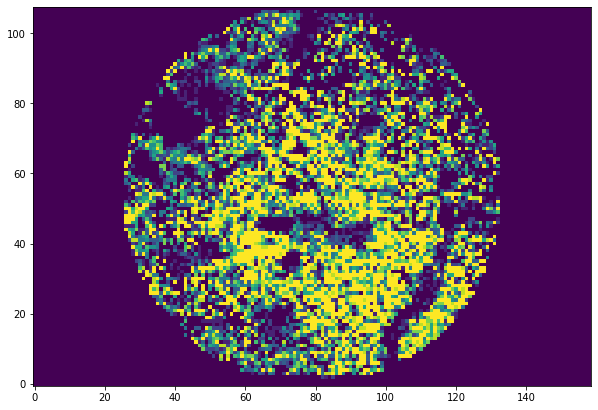

In [99]:
# sanity check the sampling matches the underlying probabilities
chosen_buckets = np.random.choice(np.arange(indices.shape[0]), 50_000, p=probabilities)

test = np.zeros(counts.shape)
for index, chosen in enumerate(chosen_buckets):
    test[tuple(indices[chosen])] += 1
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(test, origin='lower', vmax=10)
del fig, ax, test, chosen_buckets

In [100]:
class NoViablePeopleError(Exception):
    pass

In [101]:
def valid_unemployed_within_dist(y, x, dist, cache_size=200):
    counts = np.array([list(map(len, row)) for row in unemployed_bucket])
    y = y_len - int(math.ceil((y - boundary_miny) / bucket_size)) - 1
    x = int(math.ceil((x - boundary_minx) / bucket_size)) - 1
    dist = dist / bucket_size
    mask = create_circular_mask(h=y_len, w=x_len, centre_y=y, centre_x=x, radius=dist)
    
    indices = np.argwhere(mask)
    if np.sum(counts[mask]) == 0:
        raise NoViablePeopleError(f'No viable unemployed people left around (x:{x}, y:{y})')
    probabilities = counts[mask] / np.sum(counts[mask])
#     print(f'x: {x}, y: {y}, indices: {indices}, probabilities: {probabilities}')
    
    chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities) # a cache of sampled choices
    chosen_iter = iter(chosen_buckets)
    failures = 0
    
    while True:
        try:
            next_bucket_pos = tuple(indices[next(chosen_iter)])
        except StopIteration: # used up the cache, repopulate with some more random choices
            chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities)
            chosen_iter = iter(chosen_buckets)
            continue
        try: 
            next_person = unemployed_bucket[next_bucket_pos[0]][next_bucket_pos[1]].pop()
        except IndexError: # no unemployed people in that bucket
            failures += 1
            if failures > 300: # we had a lot of failures, recalc the probability map
                failures = 0
                
                counts = np.array([list(map(len, row)) for row in unemployed_bucket])
                
                total_unemployed_left = np.sum(counts[mask])
                if total_unemployed_left == 0:
                    raise NoViablePeopleError(f'No viable unemployed people left around ({x}, {y})')
                
                probabilities = counts[mask] / total_unemployed_left
                
                chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities)
                chosen_iter = iter(chosen_buckets)
            continue
            
        yield next_person

(532842.8607699374, 181995.53405587748)


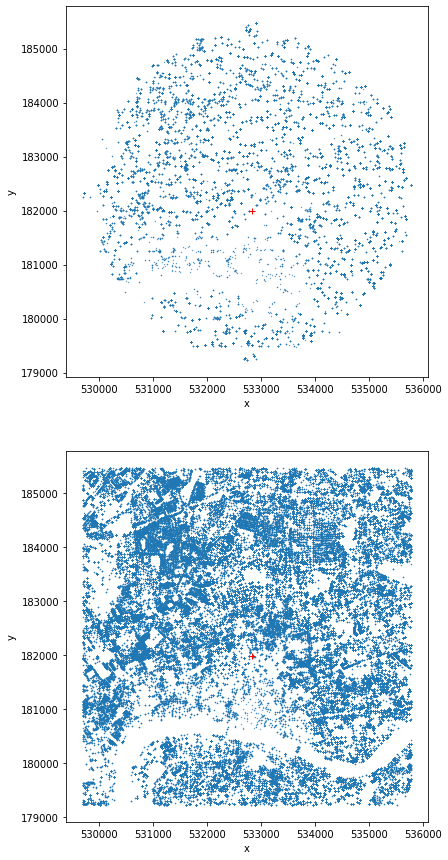

In [102]:
unemployed_bucket = make_buckets()

# pick a random workplace to query around
rand_workplace = trimmed_work.loc[[len(trimmed_work) // 3]]

(y, x) = (rand_workplace.geometry.y, rand_workplace.geometry.x)
# (y, x) = (397000, 385000)
print(f'({float(x)}, {float(y)})')
valid_unemployed_gen_5k = valid_unemployed_within_dist(y, x, 3_000)

# sanity check the sampling matches the underlying probabilities
chosen_people = [(next(valid_unemployed_gen_5k)) for i in range(45_000)]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 15))
ax1.set_aspect('equal')
ax2.set_aspect('equal')
# sanity check
chosen = people_df.loc[chosen_people]
chosen.plot(ax=ax1, x='x', y='y', kind='scatter', s=0.1)
(xmin, xmax, ymin, ymax) = (chosen['x'].min(), chosen['x'].max(), chosen['y'].min(), chosen['y'].max())
people_df[(people_df['x'] > xmin) & (people_df['x'] < xmax) & (people_df['y'] > ymin) & (people_df['y'] < ymax)].plot(ax=ax2, x='x', y='y', kind='scatter', s=0.1)

ax1.plot(x, y, 'r+')
ax2.plot(x, y, 'r+')
# rand_workplace.plot(ax=ax1, markersize=100, c='red', marker='x')
# rand_workplace.plot(ax=ax2, markersize=100, c='red', marker='x')
del fig, ax1, ax2, chosen_people, chosen, xmin, ymin, xmax, ymax, rand_workplace

In [103]:
unemployed_bucket = make_buckets()
valid_unemployed_gen_5k = valid_unemployed_within_dist(y, x, 5_000)
%timeit -r 10 -n 15_000 next(valid_unemployed_gen_5k)

2.04 µs ± 107 ns per loop (mean ± std. dev. of 10 runs, 15000 loops each)


In [104]:
del valid_unemployed_gen_5k, y, x

In [105]:
# households within 60k
# generate a probability heatmap
# ravel and sample it
# if there are no free slots set it to 0
# if 100 misses in a row, regenerate probability map

In [106]:
# pick a random vector
# query-ball around that vector
# try X vectors, then new dist

In [109]:
%%time
# uses about 5-6GB of memory for Manchester with 4400 nodes and 6200 edges 
# about 12-14GB of mem for London with 7000 nodes 16000 edges
travel_times = dict(nx.all_pairs_dijkstra_path_length(graph, cutoff=90, weight='minutes'))  # {node(str): {target(str): dist(num)}}

CPU times: user 3min 16s, sys: 1.91 s, total: 3min 18s
Wall time: 3min 19s


In [110]:
import pickle
from pathlib import Path
Path('../pickles/london/travel_times').write_bytes(pickle.dumps(travel_times))

318755563

In [51]:
from copy import deepcopy
MIN_TRAVEL_TIME = 15
graph_node_ids_to_index = {node_id: index for index, node_id in enumerate(list(graph_node_ids))}

transit_nodes_to_commuting_nodes = {graph_node_ids_to_index[src_node_id]: [target_node_id for target_node_id, time in times_dict.items() if time > MIN_TRAVEL_TIME] 
                   for src_node_id, times_dict in travel_times.items()}

def get_transit_nodes_to_commuting_nodes():
    return deepcopy(transit_nodes_to_commuting_nodes)
    
del travel_times, graph_node_ids_to_index

In [52]:
class NoNearbyTransitNodesError(Exception):
    pass

In [53]:
def get_nearby_transit_nodes(workplace):
    dist = 1_000
    nearby_transit_nodes = nodeKdTree.query_ball_point((workplace.geometry.x, workplace.geometry.y), dist)
    while len(nearby_transit_nodes) == 0 and dist <= 5_000:
        dist += 1000
        nearby_transit_nodes = nodeKdTree.query_ball_point((workplace.geometry.x, workplace.geometry.y), dist)
    if len(nearby_transit_nodes) == 0:
        raise NoNearbyTransitNodesError(f"No transit nodes were found within walking distance of workplace {workplace.index}")
    
    return nearby_transit_nodes

In [54]:
nodes_to_radius_search = dict(zip(list(graph_node_ids), list(map(lambda pos: valid_unemployed_within_dist(pos[1], pos[0], 5_000, 100), transit_node_positions))))

In [55]:
from enum import Enum
class TransportType(Enum):
    PUBLIC_TRANSIT = 0,
    DRIVING = 1,
    CYCLING = 2,
    WALKING = 3

In [56]:
%%time
to_allocate = len(unemployed)
print(f'Trying to allocate {to_allocate} people, {len(trimmed_work)} workplaces')

unemployed_bucket = make_buckets()
reachable_nodes = get_transit_nodes_to_commuting_nodes()

people_to_workplaces = [None] * len(people_df)
people_to_transport_type = [None] * len(people_df)

failures = 0
successes = 0
workplace_indices = []

for index, workplace in enumerate(trimmed_work.sample(frac=1).itertuples()): # iterate over shuffled workplaces
    if successes >= to_allocate:
        print(f'Allocated all people after {index} workplaces')
        break
    if index < 9:
        workplace_indices.append(workplace.index)
        
    transport_options = [TransportType.PUBLIC_TRANSIT, TransportType.DRIVING, TransportType.CYCLING, TransportType.WALKING]
    
    try:
        nearby_transit_nodes = get_nearby_transit_nodes(workplace)
    except NoNearbyTransitNodesError:
        transport_options.remove(TransportType.PUBLIC_TRANSIT)
        
    valid_unemployed_gen_60k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 60_000)
    valid_unemployed_gen_20k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 20_000)
    valid_unemployed_gen_5k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 5_000)
    
    for _ in range(workplace.capacity):
        # TODO update to better reflect real distributions if possible, maybe weight it by workplace size, more likely to walk if you own the business
        random.shuffle(transport_options)
        random_transport = iter(transport_options)
        
        person_id = None
        transport_type = None
        
        while (person_id == None):
            try:
                transport_type = next(random_transport)
            except StopIteration:
                break
            
            if transport_type == TransportType.PUBLIC_TRANSIT:
                source_node_index = np.random.choice(nearby_transit_nodes)
                try:
                    while (person_id == None):
                        dest_osmid = random.choice(reachable_nodes[source_node_index])
                        try:
                            person_id = next(nodes_to_radius_search[dest_osmid])
                        except StopIteration:
                            reachable_nodes[source_node_index].remove(dest_osmid)
                except (NoViablePeopleError, IndexError):
                    transport_options.remove(transport_type)
            elif transport_type == TransportType.DRIVING:
                try:
                    person_id = next(valid_unemployed_gen_60k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
            elif transport_type == TransportType.CYCLING:
                try:
                    person_id = next(valid_unemployed_gen_20k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
            elif transport_type == TransportType.WALKING:
                try:
                    person_id = next(valid_unemployed_gen_5k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
        
        if person_id:
            if transport_type:
                people_to_transport_type[person_id] = transport_type
            
            people_to_workplaces[person_id] = workplace.index
            successes += 1
            if successes >= to_allocate:
                break
        else:
            failures +=1
            continue            
    
    # workplace_row.capacity
    # workplace.index    
    
print(f'Successes: {successes}, Failures: {failures}')

Trying to allocate 482030 people, 19270 workplaces
Allocated all people after 2307 workplaces
Successes: 482030, Failures: 0
CPU times: user 19.5 s, sys: 15.6 ms, total: 19.5 s
Wall time: 19.5 s


In [1]:
from collections import defaultdict
workplaces_to_people = defaultdict(list)
for person_id, workplace_index in enumerate(people_to_workplaces):
    if workplace_index is not None:
        workplaces_to_people[workplace_index].append(person_id)

example_workplaces_to_people = {ind: workplaces_to_people[ind] for ind in workplace_indices}

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
marker_styles = [
                ('red', 'o'), ('blue', 'o'), ('green', 'o'),
                ('red', 'P'), ('blue', 'P'), ('green', 'P'),
                ('red', '*'), ('blue', '*'), ('green', '*')
                ]

for (workplace_index, worker_indices), (color, marker) in zip(example_workplaces_to_people.items(), marker_styles):
    trimmed_work.iloc[[workplace_index]].plot(ax=ax, markersize=100, c=color, marker=marker)
    workers = people_df.iloc[worker_indices]
    workers.plot(ax=ax, x='x', y='y', kind='scatter', s=30, c=color, marker=marker)
del fig, ax, workplaces_to_people

NameError: name 'people_to_workplaces' is not defined